In [18]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
experiments = 5
epochs = 100

activations = ['sigmoid', 'tanh', 'relu', 'linear', 'elu', 'selu', 'softplus', 'softsign', 'hard_sigmoid', 'LeakyReLU', 'ThresholdedReLU']
optimizers = ['rmsp']
# colors_new = ['b', 'g', 'k', 'y', 'm', 'r', 'c']
colors = ['#000000', '#330000', '#660000', '#990000', '#CC0000', '#FF0000',
          '#003300', '#006600', '#009900', '#00CC00', '#00FF00',
          '#000033', '#000066', '#000099', '#0000CC', '#0000FF',
          '#033000', '#066000', '#099000', '#0CC000', '#0FF000',
          '#000330', '#000660', '#000990', '#000CC0', '#000FF0']
colors_new = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', '#000000']
colors_opt = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#000000']
lines = ['-', '--', ':', '-.']
cols_f = []
for c in colors:
    for l in lines:
        cols_f.append(c+l)
        
columns=['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

custom_data_normd = [
    {'act': 'LeakyReLU', 'factor': '0.01'},
    {'act': 'LeakyReLU', 'factor': '1.5'},
    {'act': 'ThresholdedReLU', 'factor': '1.0'},
    {'act': 'ThresholdedReLU', 'factor': '0.13'},
    {'act': 'elu', 'factor': '0.5'},
    {'act': 'elu', 'factor': '1.5'}
]

custom_data_std = [
    {'act': 'LeakyReLU', 'factor': '0.01'},
    {'act': 'LeakyReLU', 'factor': '1.5'},
    {'act': 'ThresholdedReLU', 'factor': '1.0'},
    {'act': 'ThresholdedReLU', 'factor': '0.0'},
    {'act': 'elu', 'factor': '0.5'},
    {'act': 'elu', 'factor': '1.5'}
]


In [20]:
def data_label(prefix):
    if prefix == 'normd':
        return 'Normalized data'
    elif prefix == 'std_sample_wise':
        return 'Standardized data'


def load_data(path, prefix, activations, optimizers, experiments, units):
    data = []
    i = 0
    for act in activations:
        for opt in optimizers:
            data.append({
                'name': data_label(prefix),
                'disp_name': act + '_' + opt,
                'col': colors[i % len(colors)],
                'line': lines[i % len(lines)],
                'act': act,
                'opt':opt,
                'data' : [pd.read_csv(path + prefix + '_' + act +'_' + opt + '_' + str(ex)  + '_' + str(units) + '.csv') for ex in range(experiments)],
                'max_val_acc':{},

            })
    return data

def load_custom_data(path, prefix, configs, experiments, units):
    data = []
    i = 0
    for cfg in configs:
        factor = ''
        if cfg['act'] == 'ThresholdedReLU':
            factor = 'theta'
        else:
            factor = 'alpha'
        print(cfg)
        data.append({
            'name': '%s = %s, %s' % (factor, cfg['factor'], data_label(prefix)),
            'disp_name': '%s_rmsp_%s' % (cfg['act'], cfg['factor']),
            'col': colors[i % len(colors)],
            'line': lines[i % len(lines)],
            'act': '%s, %s = %s' % (cfg['act'], factor, cfg['factor']),
            'opt':'rmsp',
            'data' : [pd.read_csv(path + prefix + '_' + cfg['act'] + '_' + str(cfg['factor'])+'_rmsp_' + str(ex)  + '_' + str(units) + '.csv') for ex in range(experiments)],
            'max_val_acc':{},

        })
    return data

def parse_data(data, epochs, experiments):
    for d in range(len(data)):
        data[d]['averaged'] = pd.DataFrame(columns=['epoch', 'val_acc'])
        for epoch in range(epochs):
            val_acc = []

            for experiment in range(experiments):
                val_acc.append(data[d]['data'][experiment].iloc[epoch]['val_acc'])

                if epoch == 0:
                    data[d]['max_val_acc'][experiment] = {}
                    data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    data[d]['max_val_acc']['upper_max'] = {}
                    data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc']['upper_max']['epoch'] = epoch
                else:
                    if data[d]['max_val_acc'][experiment]['val_acc'] < data[d]['data'][experiment].iloc[epoch]['val_acc']:
                        data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    if data[d]['data'][experiment].iloc[epoch]['val_acc'] > data[d]['max_val_acc']['upper_max']['val_acc']:
                        data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc']['upper_max']['epoch'] = epoch


            av_val_acc = sum(val_acc)/len(val_acc)

            if epoch == 0:
                data[d]['max_val_acc']['avg'] = {}
                data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                data[d]['max_val_acc']['avg']['epoch'] = epoch
            else:
                if(av_val_acc >= data[d]['max_val_acc']['avg']['val_acc']):
                    data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                    data[d]['max_val_acc']['avg']['epoch'] = epoch

            data[d]['averaged'] = data[d]['averaged'].append({
                'epoch': epoch,
                'val_acc': av_val_acc
            }, ignore_index=True)
            
        data[d]['max_val_acc']['last_max'] = max([data[d]['data'][experiment]['val_acc'].tolist()[-1] for experiment in range(experiments)])
    
    return data

In [21]:
data_normd = load_data('./training_logs/', 'normd', activations, optimizers, experiments, 64)
data_normd = parse_data(data_normd, epochs, experiments)

data_std = load_data('./training_logs/', 'std_sample_wise', activations, optimizers, experiments, 64)
data_std = parse_data(data_std, epochs, experiments)

In [22]:
data_normd_custom = load_custom_data('./training_logs/', 'normd', custom_data_normd, experiments, 64)
data_normd_custom = parse_data(data_normd_custom, epochs, experiments)

data_std_custom = load_custom_data('./training_logs/', 'std_sample_wise', custom_data_std, experiments, 64)
data_std_custom = parse_data(data_std_custom, epochs, experiments)


{'act': 'LeakyReLU', 'factor': '0.01'}
{'act': 'LeakyReLU', 'factor': '1.5'}
{'act': 'ThresholdedReLU', 'factor': '1.0'}
{'act': 'ThresholdedReLU', 'factor': '0.13'}
{'act': 'elu', 'factor': '0.5'}
{'act': 'elu', 'factor': '1.5'}
{'act': 'LeakyReLU', 'factor': '0.01'}
{'act': 'LeakyReLU', 'factor': '1.5'}
{'act': 'ThresholdedReLU', 'factor': '1.0'}
{'act': 'ThresholdedReLU', 'factor': '0.0'}
{'act': 'elu', 'factor': '0.5'}
{'act': 'elu', 'factor': '1.5'}


In [23]:
check_normd = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act'])
i=0
for d in range(len(data_normd)):
    for experiment in range(experiments):
        check_normd.loc[i] = [data_normd[d]['disp_name'], 
                          experiment,
                          data_normd[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_normd[d]['opt'], 
                          data_normd[d]['act']]
        i+=1

check_normd = check_normd.sort_values(by=['val_acc'])
check_normd

,config,exp,acc,loss,val_acc,val_loss,opt,act
50,ThresholdedReLU_rmsp,0,0.823900,0.646727,0.8400,0.576850,rmsp,ThresholdedReLU
53,ThresholdedReLU_rmsp,3,0.849533,0.577091,0.8548,0.526089,rmsp,ThresholdedReLU
52,ThresholdedReLU_rmsp,2,0.836450,0.638381,0.8558,0.535514,rmsp,ThresholdedReLU
54,ThresholdedReLU_rmsp,4,0.854300,0.582374,0.8896,0.461609,rmsp,ThresholdedReLU
51,ThresholdedReLU_rmsp,1,0.867900,0.549635,0.8916,0.457510,rmsp,ThresholdedReLU
15,linear_rmsp,0,0.920033,0.296879,0.9174,0.303291,rmsp,linear
16,linear_rmsp,1,0.919383,0.295300,0.9231,0.295486,rmsp,linear
19,linear_rmsp,4,0.920733,0.297134,0.9232,0.291917,rmsp,linear
18,linear_rmsp,3,0.919067,0.296410,0.9239,0.293230,rmsp,linear
17,linear_rmsp,2,0.918317,0.295804,0.9241,0.289266,rmsp,linear


In [24]:
check_normd_custom = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act'])
i=0
for d in range(len(data_normd_custom)):
    for experiment in range(experiments):
        check_normd_custom.loc[i] = [data_normd_custom[d]['disp_name'], 
                          experiment,
                          data_normd_custom[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_normd_custom[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_normd_custom[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_normd_custom[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_normd_custom[d]['opt'], 
                          data_normd_custom[d]['act']]
        i+=1

check_normd_custom = check_normd_custom.sort_values(by=['val_acc'])
check_normd_custom

,config,exp,acc,loss,val_acc,val_loss,opt,act
11,ThresholdedReLU_rmsp_1.0,1,0.687700,0.976001,0.7119,0.920513,rmsp,"ThresholdedReLU, theta = 1.0"
14,ThresholdedReLU_rmsp_1.0,4,0.720467,0.899824,0.7350,0.891314,rmsp,"ThresholdedReLU, theta = 1.0"
13,ThresholdedReLU_rmsp_1.0,3,0.727117,0.875196,0.7588,0.821162,rmsp,"ThresholdedReLU, theta = 1.0"
10,ThresholdedReLU_rmsp_1.0,0,0.775900,0.776944,0.7830,0.764207,rmsp,"ThresholdedReLU, theta = 1.0"
12,ThresholdedReLU_rmsp_1.0,2,0.770950,0.768798,0.7845,0.711652,rmsp,"ThresholdedReLU, theta = 1.0"
8,LeakyReLU_rmsp_1.5,3,0.930350,0.245957,0.9373,0.231052,rmsp,"LeakyReLU, alpha = 1.5"
6,LeakyReLU_rmsp_1.5,1,0.931733,0.247605,0.9391,0.234473,rmsp,"LeakyReLU, alpha = 1.5"
7,LeakyReLU_rmsp_1.5,2,0.930850,0.247797,0.9413,0.227503,rmsp,"LeakyReLU, alpha = 1.5"
5,LeakyReLU_rmsp_1.5,0,0.930583,0.248841,0.9417,0.222671,rmsp,"LeakyReLU, alpha = 1.5"
9,LeakyReLU_rmsp_1.5,4,0.931650,0.245824,0.9421,0.223703,rmsp,"LeakyReLU, alpha = 1.5"


In [25]:
check_std = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act'])
i=0
for d in range(len(data_std)):
    for experiment in range(experiments):
        check_std.loc[i] = [data_std[d]['disp_name'], 
                          experiment,
                          data_std[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_std[d]['opt'], 
                          data_std[d]['act']]
        i+=1
check_std = check_std.sort_values(by=['val_acc'])
check_std

,config,exp,acc,loss,val_acc,val_loss,opt,act
19,linear_rmsp,4,0.918150,0.292799,0.9119,0.319595,rmsp,linear
15,linear_rmsp,0,0.918467,0.290846,0.9148,0.307485,rmsp,linear
16,linear_rmsp,1,0.918283,0.294361,0.9153,0.301252,rmsp,linear
18,linear_rmsp,3,0.918683,0.293428,0.9177,0.302055,rmsp,linear
17,linear_rmsp,2,0.918317,0.292027,0.9228,0.295457,rmsp,linear
51,ThresholdedReLU_rmsp,1,0.958333,0.254541,0.9643,0.300646,rmsp,ThresholdedReLU
52,ThresholdedReLU_rmsp,2,0.962933,0.215165,0.9650,0.252072,rmsp,ThresholdedReLU
53,ThresholdedReLU_rmsp,3,0.964300,0.207722,0.9657,0.291388,rmsp,ThresholdedReLU
54,ThresholdedReLU_rmsp,4,0.959550,0.230708,0.9661,0.261932,rmsp,ThresholdedReLU
50,ThresholdedReLU_rmsp,0,0.954367,0.267065,0.9663,0.293679,rmsp,ThresholdedReLU


In [26]:
check_std_custom = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act'])
i=0
for d in range(len(data_std_custom)):
    for experiment in range(experiments):
        check_std_custom.loc[i] = [data_std_custom[d]['disp_name'], 
                          experiment,
                          data_std_custom[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_std_custom[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_std_custom[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_std_custom[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_std_custom[d]['opt'], 
                          data_std_custom[d]['act']]
        i+=1
check_std_custom = check_std_custom.sort_values(by=['val_acc'])
check_std_custom

,config,exp,acc,loss,val_acc,val_loss,opt,act
6,LeakyReLU_rmsp_1.5,1,0.930350,0.245013,0.9331,0.244399,rmsp,"LeakyReLU, alpha = 1.5"
9,LeakyReLU_rmsp_1.5,4,0.930650,0.244386,0.9363,0.230675,rmsp,"LeakyReLU, alpha = 1.5"
5,LeakyReLU_rmsp_1.5,0,0.929333,0.244685,0.9368,0.230931,rmsp,"LeakyReLU, alpha = 1.5"
7,LeakyReLU_rmsp_1.5,2,0.930367,0.243537,0.9395,0.227917,rmsp,"LeakyReLU, alpha = 1.5"
8,LeakyReLU_rmsp_1.5,3,0.931100,0.242366,0.9404,0.218197,rmsp,"LeakyReLU, alpha = 1.5"
11,ThresholdedReLU_rmsp_1.0,1,0.931683,0.372117,0.9477,0.358582,rmsp,"ThresholdedReLU, theta = 1.0"
12,ThresholdedReLU_rmsp_1.0,2,0.936633,0.323847,0.9562,0.305785,rmsp,"ThresholdedReLU, theta = 1.0"
13,ThresholdedReLU_rmsp_1.0,3,0.944867,0.300713,0.9614,0.302615,rmsp,"ThresholdedReLU, theta = 1.0"
10,ThresholdedReLU_rmsp_1.0,0,0.945317,0.310324,0.9616,0.283669,rmsp,"ThresholdedReLU, theta = 1.0"
14,ThresholdedReLU_rmsp_1.0,4,0.957083,0.240178,0.9623,0.307426,rmsp,"ThresholdedReLU, theta = 1.0"


In [27]:
results = pd.DataFrame(columns=['Activation', 
                                'Normd: Averaged on Last Epoch', 
                                      'Std: Averaged on Last Epoch', 
                                'Normd: Averaged Max Achieved',
                                      'Std: Averaged Max Achieved',
                                'Normd: Overall Max on Last Epoch',
                                      'Std: Overall Max on Last Epoch',
                                'Normd: Overall Max Achieved',
                                      'Std: Overall Max Achieved',
                                'Overall Max',
                                'Normd: Averaged Max Epoch',
                                      'Std: Averaged Max Epoch'
                                
                               ])

for i in range(len(data_normd)):
    results.loc[i] = [
        data_normd[i]['act'],
        data_normd[i]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_std[i]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_normd[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_std[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_normd[i]['max_val_acc']['last_max'] * 100,
        data_std[i]['max_val_acc']['last_max'] * 100,
        data_normd[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        max([data_normd[i]['max_val_acc']['upper_max']['val_acc'], 
             data_std[i]['max_val_acc']['upper_max']['val_acc']])* 100,
        data_normd[i]['max_val_acc']['avg']['epoch'],
        data_std[i]['max_val_acc']['avg']['epoch']
        
    ]
    
for i in range(len(data_normd_custom)):
    results.loc[i + len(data_normd)] = [
        data_normd_custom[i]['act'],
        data_normd_custom[i]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_std_custom[i]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_normd_custom[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_std_custom[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_normd_custom[i]['max_val_acc']['last_max'] * 100,
        data_std_custom[i]['max_val_acc']['last_max'] * 100,
        data_normd_custom[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std_custom[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        max([data_normd_custom[i]['max_val_acc']['upper_max']['val_acc'], data_std_custom[i]['max_val_acc']['upper_max']['val_acc']])* 100,
        data_normd_custom[i]['max_val_acc']['avg']['epoch'],
        data_std_custom[i]['max_val_acc']['avg']['epoch']
    ]

results_sorted = results.sort_values(by=['Overall Max'], ascending = False)
results_sorted.to_csv('./results.csv')
results_sorted

,Activation,Normd: Averaged on Last Epoch,Std: Averaged on Last Epoch,Normd: Averaged Max Achieved,Std: Averaged Max Achieved,Normd: Overall Max on Last Epoch,Std: Overall Max on Last Epoch,Normd: Overall Max Achieved,Std: Overall Max Achieved,Overall Max,Normd: Averaged Max Epoch,Std: Averaged Max Epoch
5,selu,97.900,97.792,97.982,97.990,97.99,97.88,98.20,98.13,98.20,80,54
4,elu,97.880,97.624,98.016,97.802,97.93,97.77,98.17,97.98,98.17,69,71
16,"elu, alpha = 1.5",97.894,97.786,97.966,97.914,97.96,97.89,98.09,98.10,98.10,98,42
15,"elu, alpha = 0.5",97.866,97.506,97.902,97.722,97.94,97.75,98.10,97.91,98.10,77,52
6,softplus,97.636,97.166,97.766,97.622,97.69,97.35,97.90,97.79,97.90,45,27
14,"ThresholdedReLU, theta = 0.13",97.092,97.306,97.382,97.498,97.18,97.60,97.56,97.78,97.78,19,49
0,sigmoid,97.536,97.338,97.624,97.450,97.61,97.47,97.77,97.64,97.77,86,39
2,relu,97.424,97.134,97.550,97.460,97.52,97.37,97.77,97.73,97.77,34,27
8,hard_sigmoid,97.412,97.386,97.496,97.412,97.57,97.48,97.77,97.62,97.77,96,71
1,tanh,97.486,97.304,97.578,97.388,97.65,97.37,97.76,97.60,97.76,62,68


In [29]:
activation_stats = results_sorted.describe()
activation_stats.to_csv('./activation_stats.csv')
activation_stats

,Normd: Averaged on Last Epoch,Std: Averaged on Last Epoch,Normd: Averaged Max Achieved,Std: Averaged Max Achieved,Normd: Overall Max on Last Epoch,Std: Overall Max on Last Epoch,Normd: Overall Max Achieved,Std: Overall Max Achieved,Overall Max
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,95.084941,96.710706,96.740471,96.930471,95.503529,96.909412,97.029412,97.169412,97.241176
std,5.837060,1.627610,1.840265,1.541170,5.015424,1.504092,1.639228,1.448924,1.465204
min,75.464000,91.650000,92.496000,92.154000,78.450000,92.280000,92.760000,92.680000,92.760000
25%,97.092000,97.134000,97.320000,97.352000,97.180000,97.320000,97.490000,97.520000,97.520000
50%,97.412000,97.306000,97.550000,97.460000,97.520000,97.470000,97.760000,97.640000,97.770000
75%,97.636000,97.444000,97.766000,97.622000,97.690000,97.600000,97.900000,97.790000,97.900000
max,97.900000,97.792000,98.016000,97.990000,97.990000,97.890000,98.200000,98.130000,98.200000


In [30]:
results_normd = pd.DataFrame(columns=['Activation', 
                                'Averaged on Last Epoch', 
                                'Averaged Max Achieved',
                                'Overall Max on Last Epoch',
                                'Overall Max Achieved',
                                'Averaged Max Epoch'
                               ])

for i in range(len(data_normd)):
    results_normd.loc[i] = [
        data_normd[i]['act'],
        data_normd[i]['averaged']['val_acc'].tolist()[-1] * 100,
        data_normd[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_normd[i]['max_val_acc']['last_max'] * 100,
        data_normd[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_normd[i]['max_val_acc']['avg']['epoch']
    ]
    
for i in range(len(data_normd_custom)):
    results_normd.loc[i + len(data_normd)] = [
        data_normd_custom[i]['act'],
        data_normd_custom[i]['averaged']['val_acc'].tolist()[-1] * 100,
        data_normd_custom[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_normd_custom[i]['max_val_acc']['last_max'] * 100,
        data_normd_custom[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_normd_custom[i]['max_val_acc']['avg']['epoch']
    ]
    
results_normd.to_csv('./results_normd.csv')
results_normd.sort_values(by=['Overall Max Achieved'], ascending = False)

,Activation,Averaged on Last Epoch,Averaged Max Achieved,Overall Max on Last Epoch,Overall Max Achieved,Averaged Max Epoch
5,selu,97.900,97.982,97.99,98.20,80
4,elu,97.880,98.016,97.93,98.17,69
15,"elu, alpha = 0.5",97.866,97.902,97.94,98.10,77
16,"elu, alpha = 1.5",97.894,97.966,97.96,98.09,98
6,softplus,97.636,97.766,97.69,97.90,45
0,sigmoid,97.536,97.624,97.61,97.77,86
2,relu,97.424,97.550,97.52,97.77,34
8,hard_sigmoid,97.412,97.496,97.57,97.77,96
1,tanh,97.486,97.578,97.65,97.76,62
11,"LeakyReLU, alpha = 0.01",97.356,97.552,97.48,97.73,28


In [34]:
results_std = pd.DataFrame(columns=['Activation', 
                                      'Averaged on Last Epoch', 
                                      'Averaged Max Achieved',
                                      'Overall Max on Last Epoch',
                                      'Overall Max Achieved',
                                      'Averaged Max Epoch'
                               ])

for i in range(len(data_std)):
    results_std.loc[i] = [
        data_std[i]['act'],
        data_std[i]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_std[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_std[i]['max_val_acc']['last_max'] * 100,
        data_std[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std[i]['max_val_acc']['avg']['epoch']
    ]
    
for i in range(len(data_std_custom)):
    results_std.loc[i + len(data_std)] = [
        data_std_custom[i]['act'],
        data_std_custom[i]['averaged']['val_acc'].tolist()[-1] * 100,
        data_std_custom[i]['max_val_acc']['avg']['val_acc'] * 100,
        data_std_custom[i]['max_val_acc']['last_max'] * 100,
        data_std_custom[i]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std_custom[i]['max_val_acc']['avg']['epoch']
    ]
    

results_std_sorted = results_std.sort_values(by=['Overall Max Achieved'], ascending = False)
results_std_sorted.to_csv('./results_std.csv')
results_std_sorted

,Activation,Averaged on Last Epoch,Averaged Max Achieved,Overall Max on Last Epoch,Overall Max Achieved,Averaged Max Epoch
5,selu,97.792,97.990,97.88,98.13,54
16,"elu, alpha = 1.5",97.786,97.914,97.89,98.10,42
4,elu,97.624,97.802,97.77,97.98,71
15,"elu, alpha = 0.5",97.506,97.722,97.75,97.91,52
6,softplus,97.166,97.622,97.35,97.79,27
14,"ThresholdedReLU, theta = 0.0",97.306,97.498,97.60,97.78,49
2,relu,97.134,97.460,97.37,97.73,27
7,softsign,97.444,97.506,97.56,97.67,79
0,sigmoid,97.338,97.450,97.47,97.64,39
11,"LeakyReLU, alpha = 0.01",97.286,97.468,97.32,97.63,30


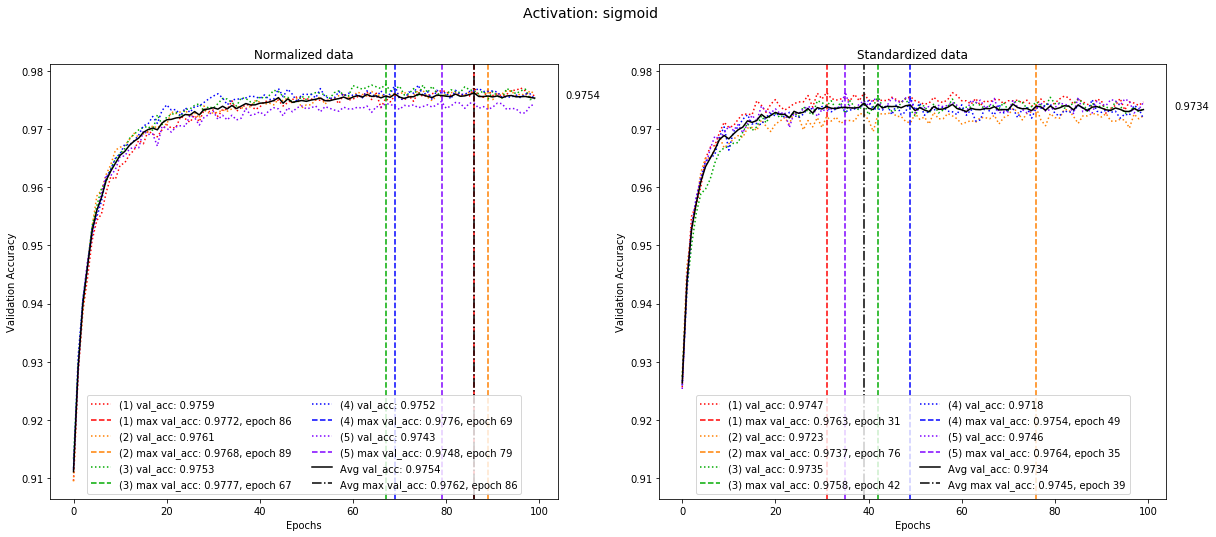

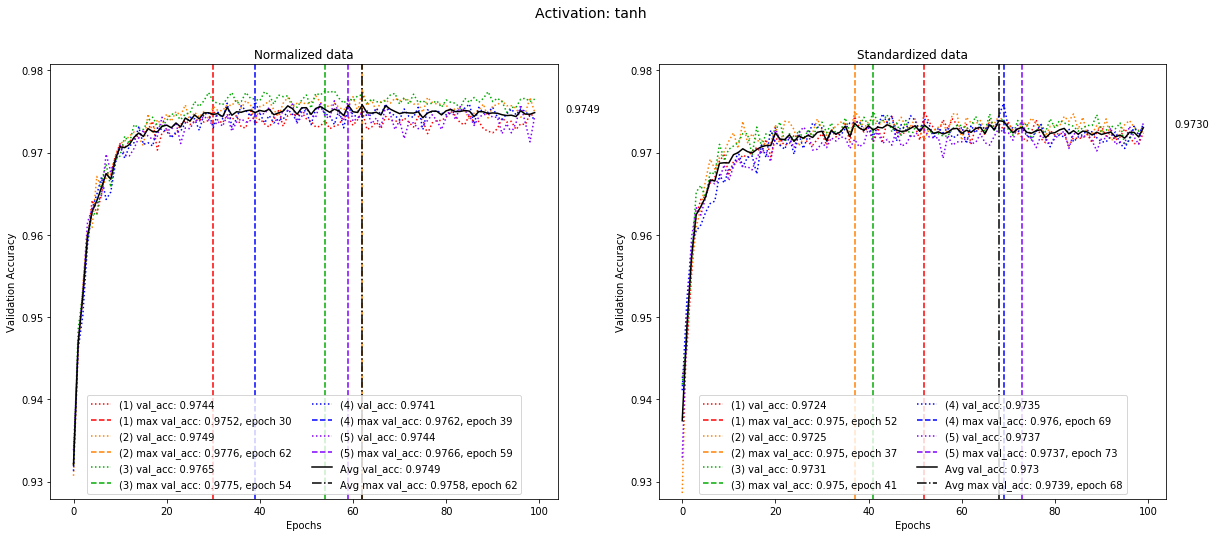

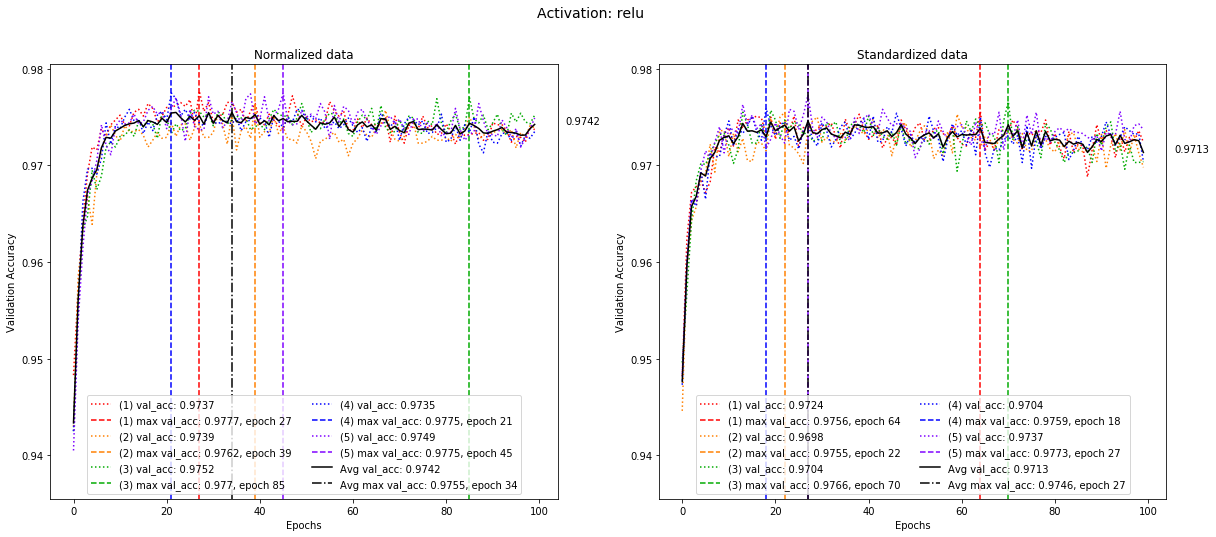

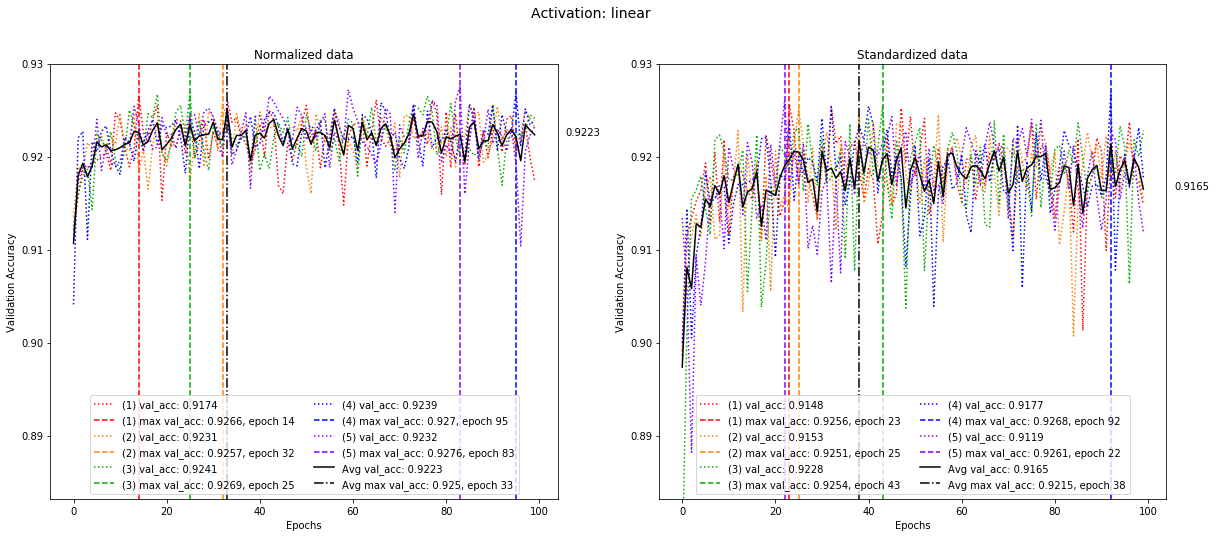

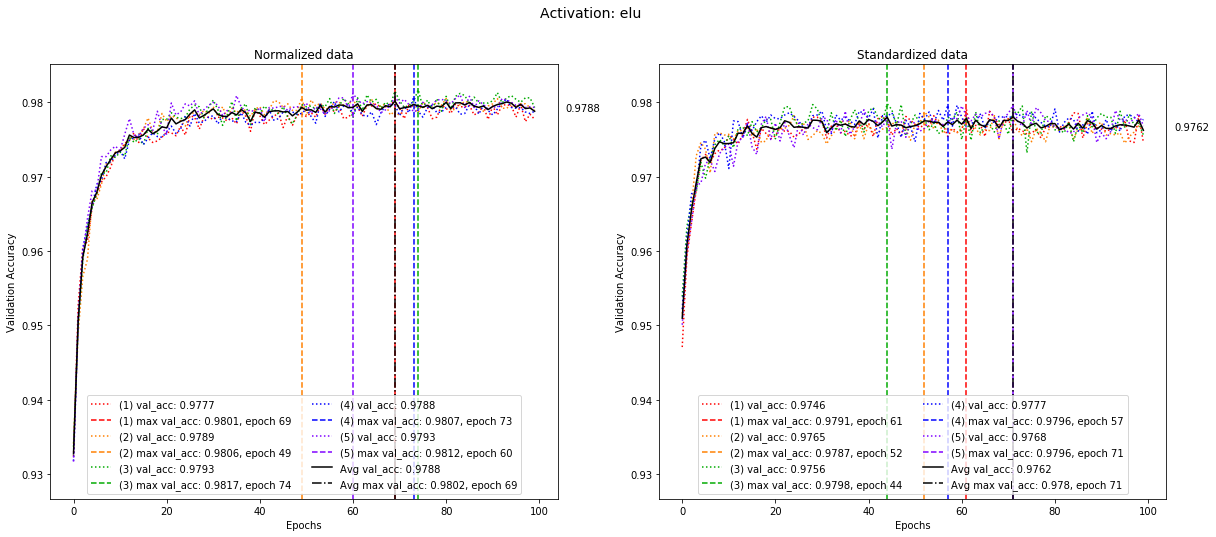

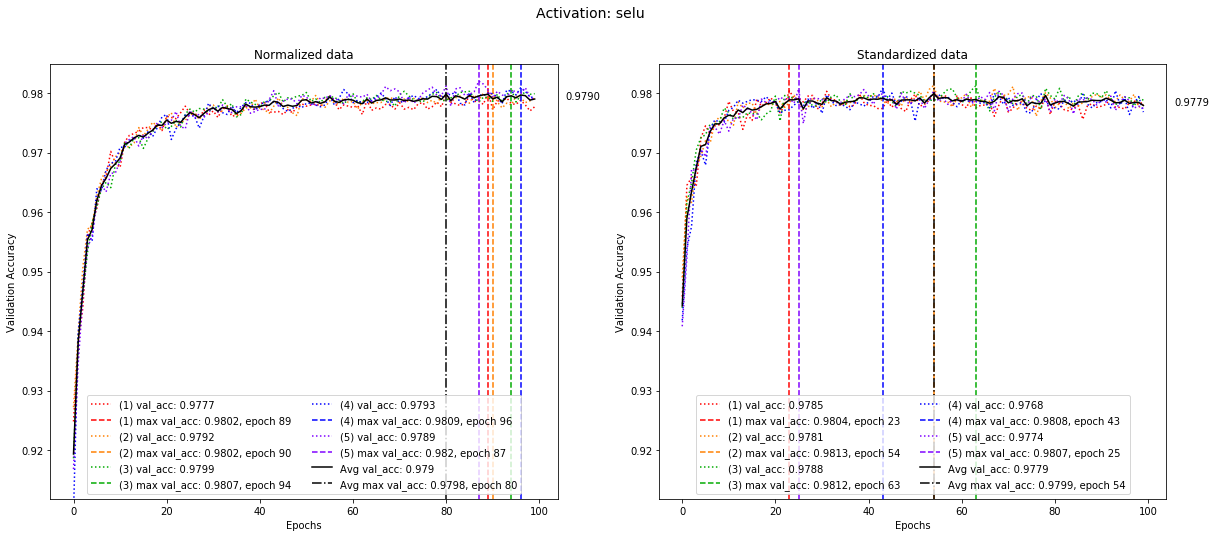

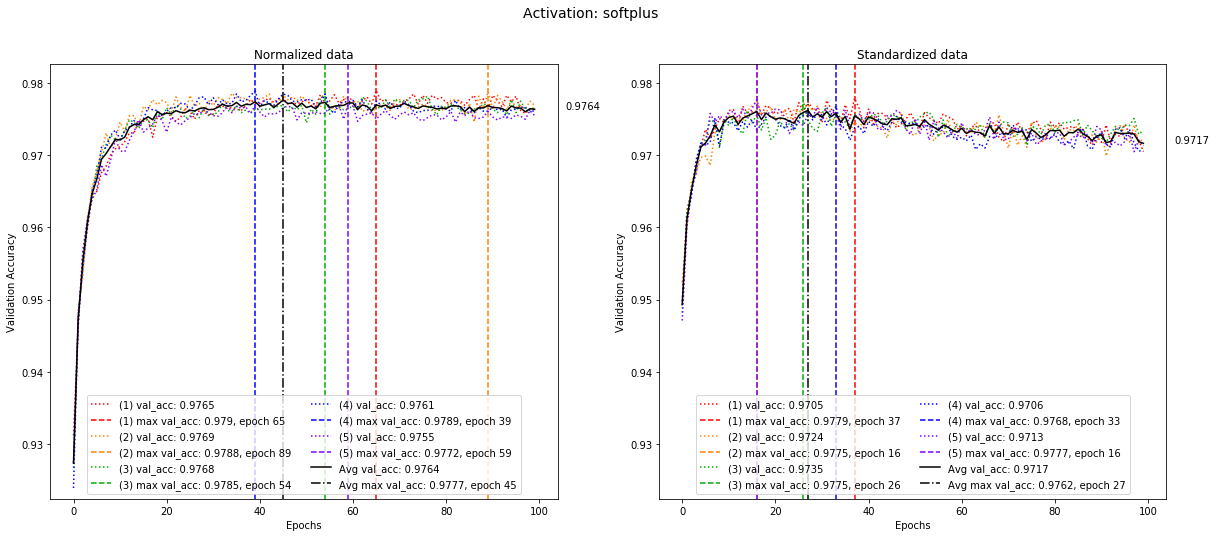

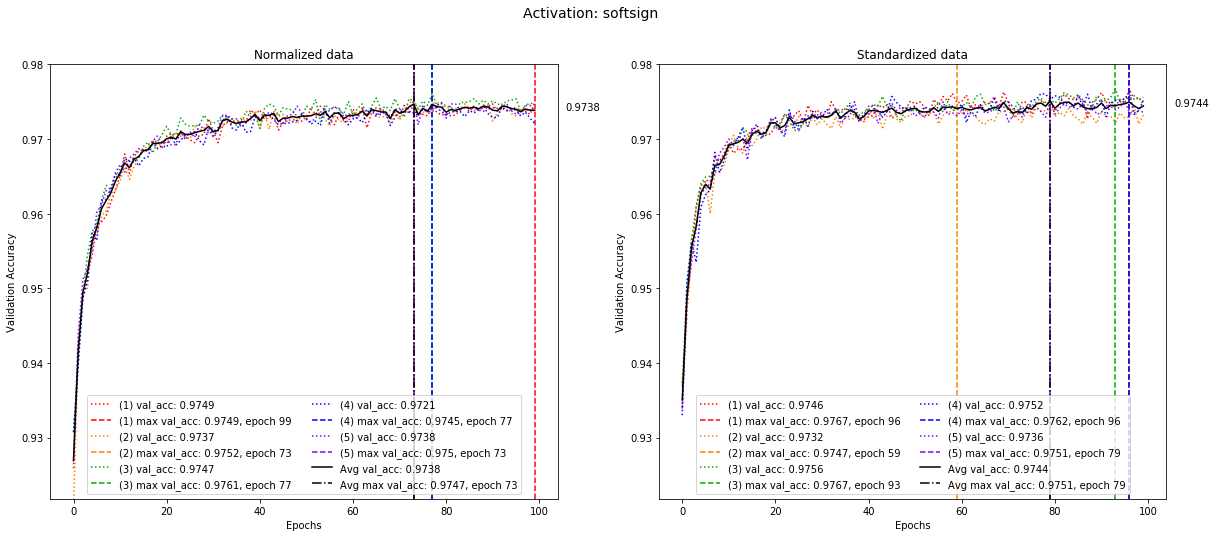

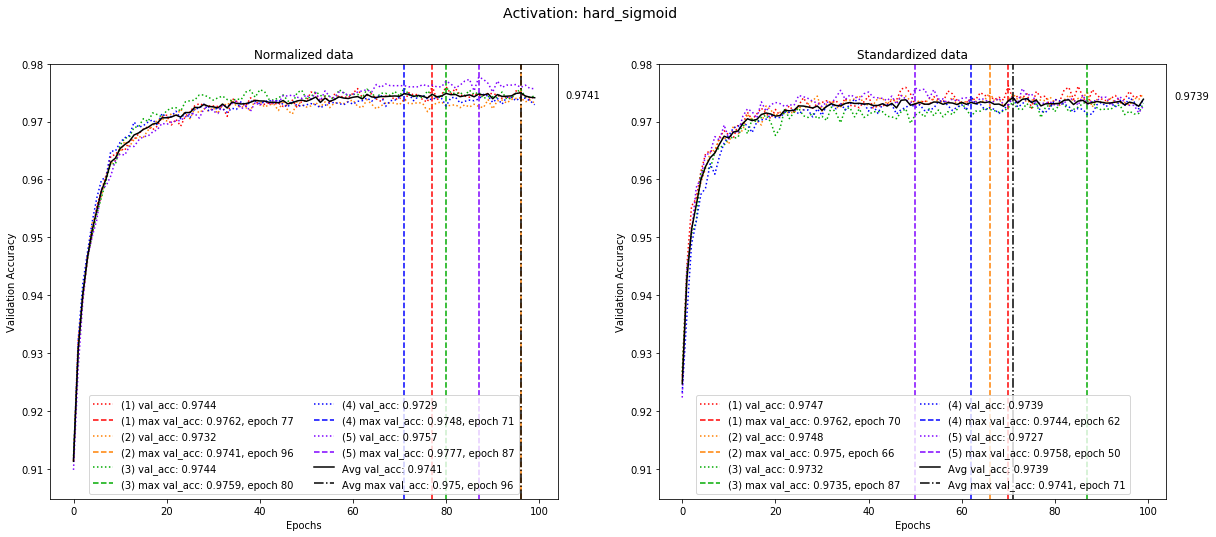

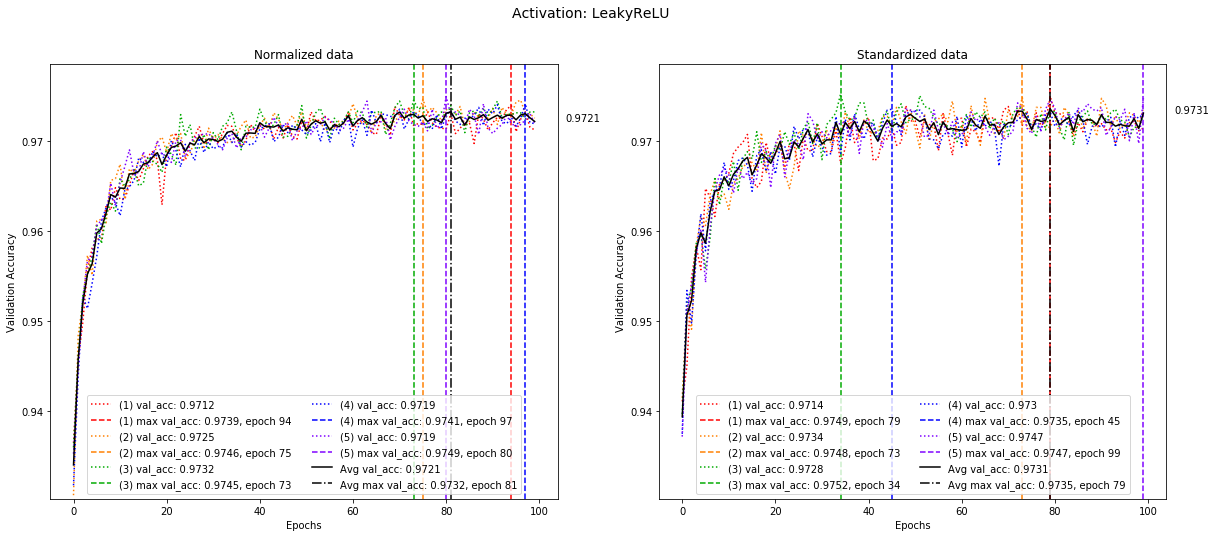

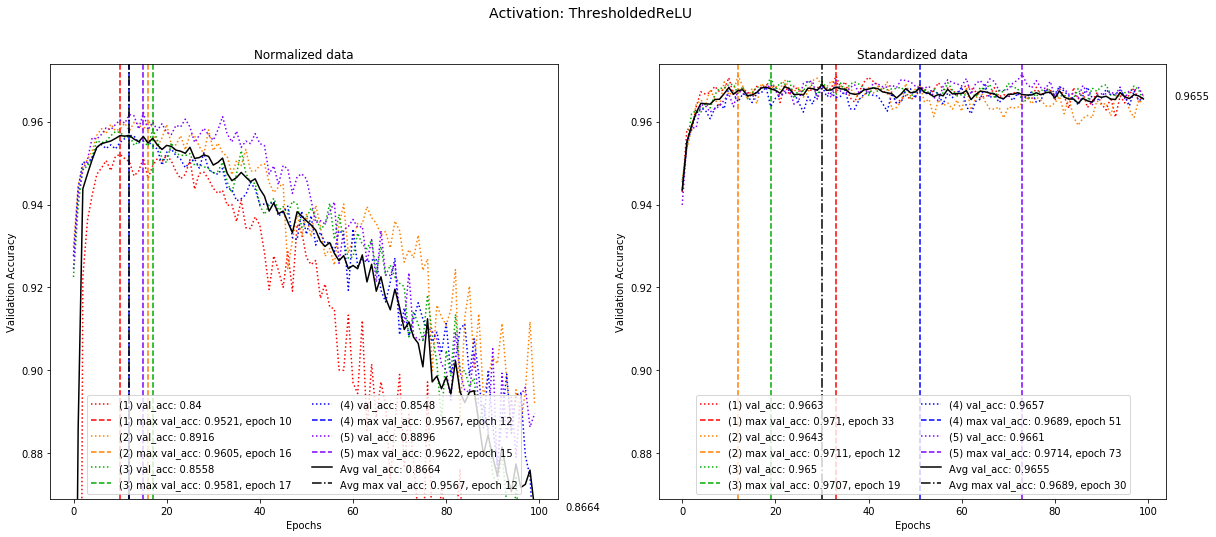

In [32]:
for d in range(len(data_normd)):

    clr = 0
    plt.figure(figsize=(20,8))
    plt.suptitle('Activation: ' + data_normd[d]['act'], fontsize=14)
    plt.subplot(1,2,1)
    plt.title(data_normd[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_normd[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_normd[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_normd[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_normd[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_normd[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_normd[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_normd[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=2)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), min(data_std[d]['data'][i]['val_acc'].tolist())]) - 0.005, max([data_normd[d]['max_val_acc']['avg']['val_acc'], data_std[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')
    
    clr = 0
    plt.subplot(1,2,2)
    plt.title(data_std[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_std[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_std[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_std[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_std[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_std[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_std[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_std[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_std[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=2)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), min(data_std[d]['data'][i]['val_acc'].tolist())]) - 0.005, max([data_normd[d]['max_val_acc']['avg']['val_acc'], data_std[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')
    plt.show()
    
    

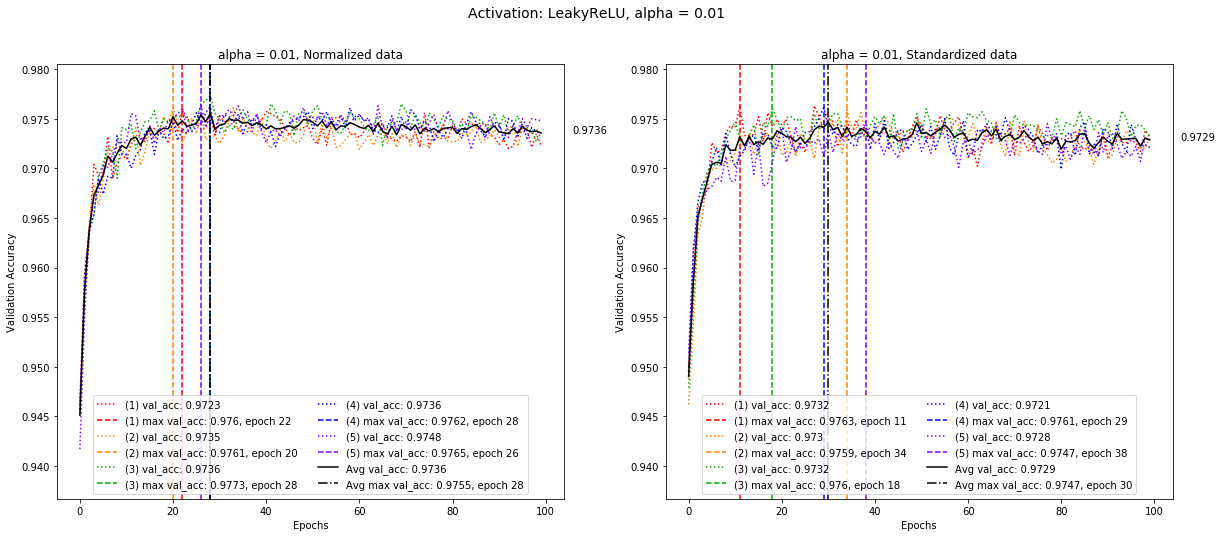

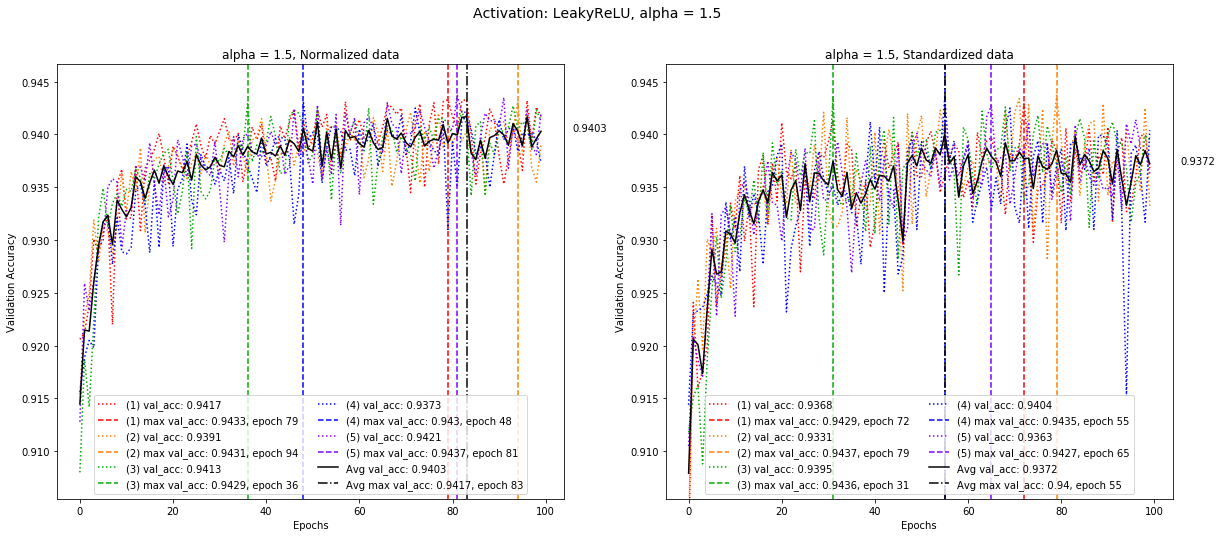

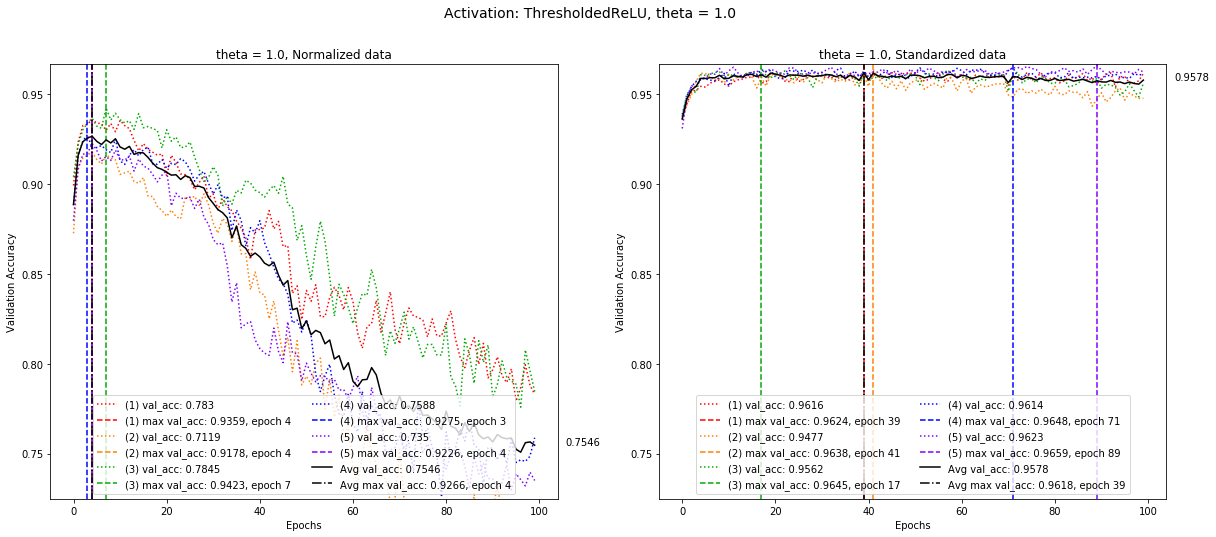

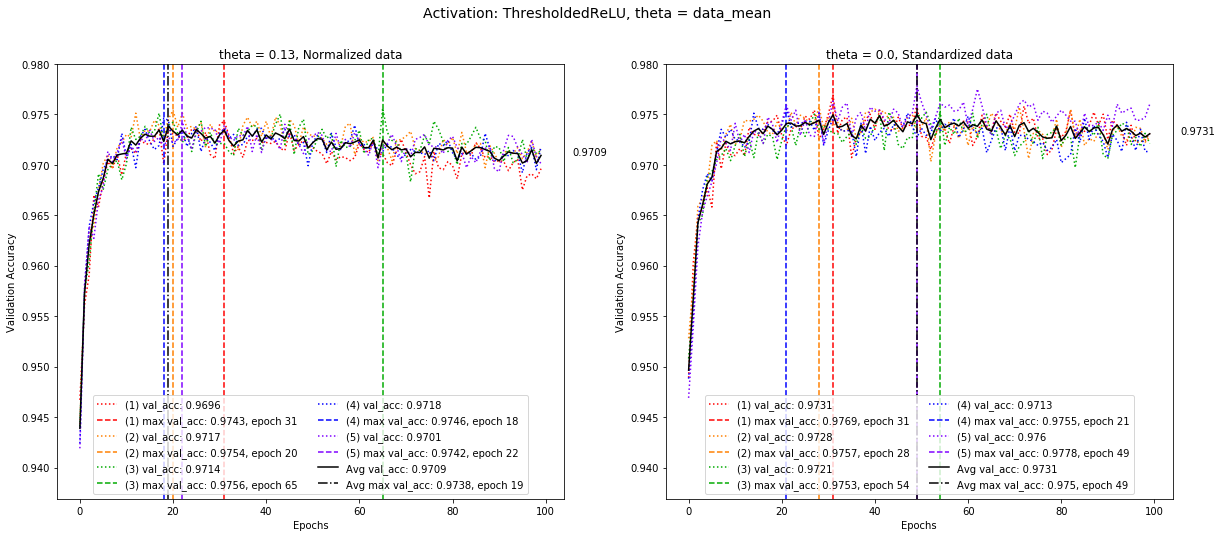

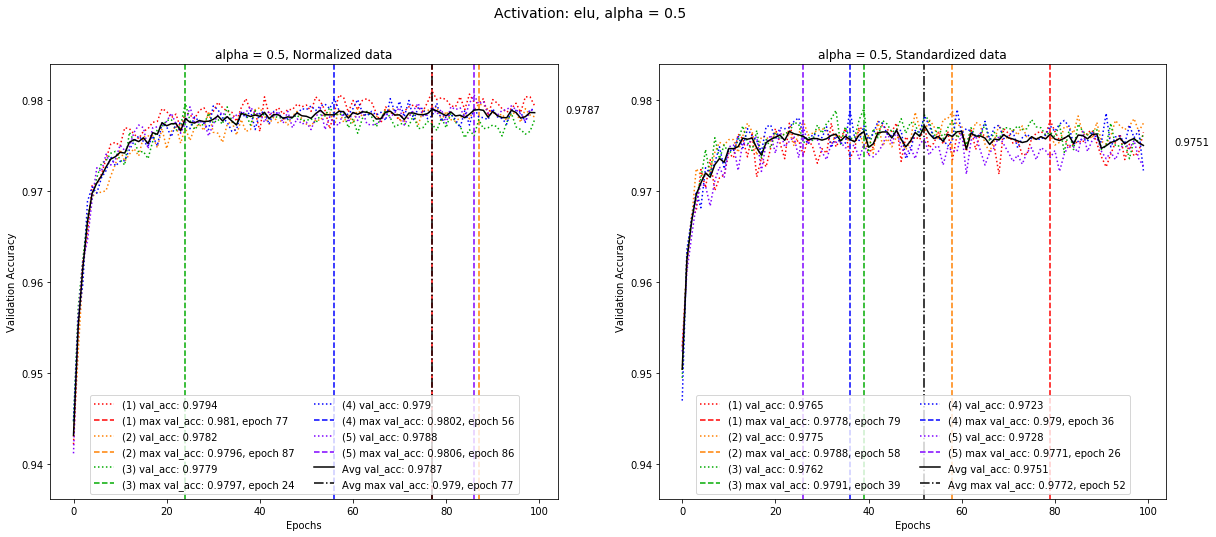

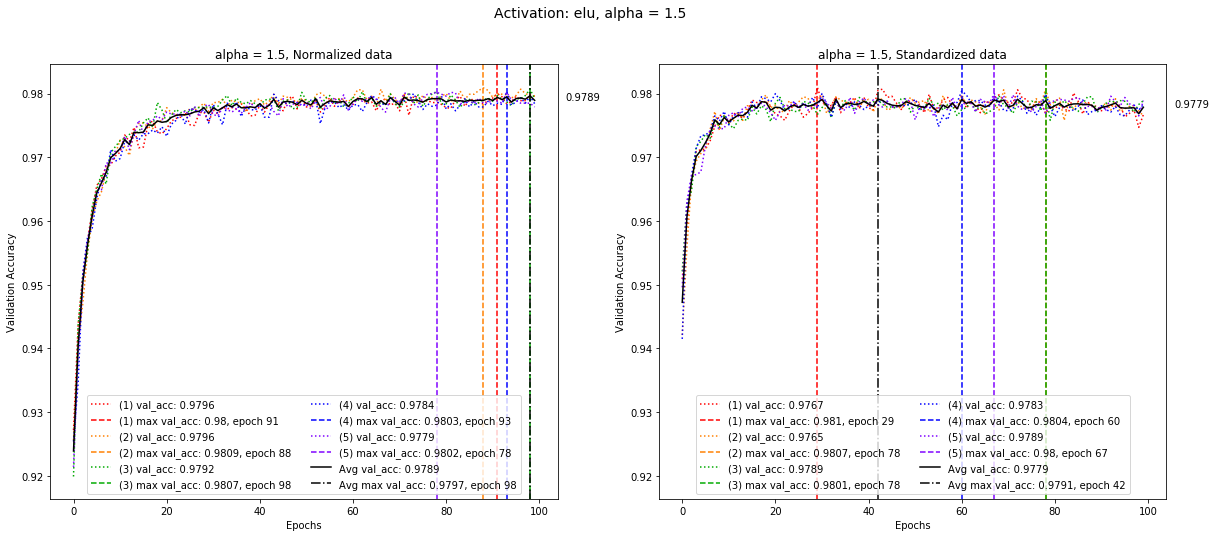

In [33]:
for d in range(len(data_normd_custom)):

    clr = 0
    plt.figure(figsize=(20,8))
    custom_name = False
    if data_normd_custom[d]['act'] == 'ThresholdedReLU, theta = 0.13':
        custom_name = True
    
    if custom_name:
        plt.suptitle('Activation: ThresholdedReLU, theta = data_mean', fontsize=14)
    else:
        plt.suptitle('Activation: ' + data_normd_custom[d]['act'], fontsize=14)
    plt.subplot(1,2,1)
    plt.title(data_normd_custom[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_normd_custom[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_normd_custom[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_normd_custom[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_normd_custom[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_normd_custom[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_normd_custom[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_normd_custom[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd_custom[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_normd_custom[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd_custom[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd_custom[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd_custom[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=2)
    plt.ylim(min([min(data_normd_custom[d]['data'][i]['val_acc'].tolist()), min(data_std_custom[d]['data'][i]['val_acc'].tolist())]) - 0.005, max([data_normd_custom[d]['max_val_acc']['avg']['val_acc'], data_std_custom[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')
    
    clr = 0
    plt.subplot(1,2,2)
    plt.title(data_std_custom[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_std_custom[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_std_custom[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_std_custom[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_std_custom[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_std_custom[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_std_custom[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_std_custom[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std_custom[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_std_custom[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std_custom[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std_custom[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std_custom[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=2)
    plt.ylim(min([min(data_normd_custom[d]['data'][i]['val_acc'].tolist()), min(data_std_custom[d]['data'][i]['val_acc'].tolist())]) - 0.005, max([data_normd_custom[d]['max_val_acc']['avg']['val_acc'], data_std_custom[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')
    plt.show()
    
    